## Ethanol/Water Example

In [57]:
import os
import warnings

import matplotlib.pyplot as plt

from kbkit.core import KBPipeline
from kbkit.viz import Plotter

warnings.filterwarnings("ignore")

### Build and Run KBPipeline

In [58]:
# extract info from prj_name
prj = "test_data/ethanol_water_26C"


# create & run pipeline
pipe = KBPipeline(
    pure_path="test_data/pure_components",
    pure_systems=["ETHOL_300", "SPCEW_300"],
    base_path=prj,
    rdf_dir="kbi_rdf_files_gmx25",
    start_time=10000,
    ensemble="npt",
)

pipe.run()

running pipeline for ethanol_water_26C


### Make Figures from Pipeline

In [59]:
# initialize plotter
plotter = Plotter(
    pipeline=pipe,
    molecule_map={"ETHOL": "ethanol", "SPCEW": "water"},
    x_mol="ETHOL",
)

In [60]:
plotter.make_figures()

#### Plot Individual Figures

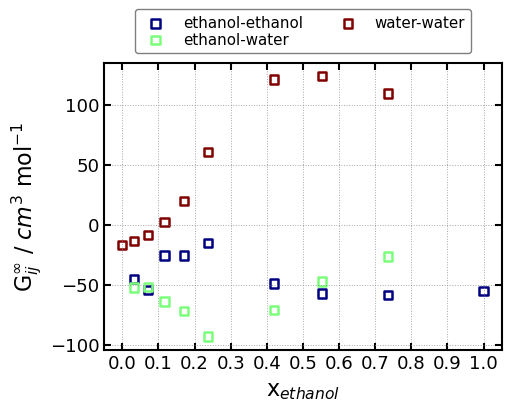

In [5]:
fig, ax = plotter.plot_kbis(units="cm^3/mol", show=True)

In [6]:
# Get list of all available properties to plot

plotter.available_properties()

['kbi',
 'lngammas',
 'dlngammas',
 'lngammas_fits',
 'dlngammas_fits',
 'excess',
 'mixing',
 'gm',
 'ge',
 'hmix',
 'se',
 'i0',
 'det_h']

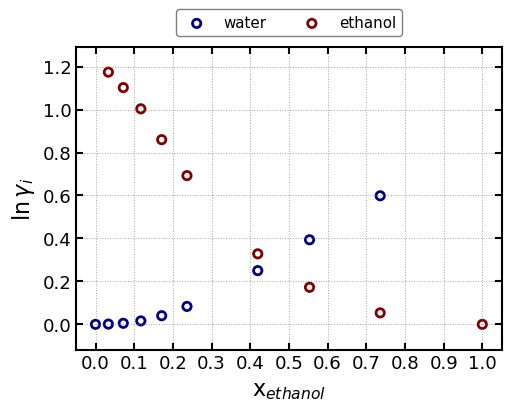

In [7]:
fig, ax = plotter.plot("lngammas", show=True)  # plot activity coefficients

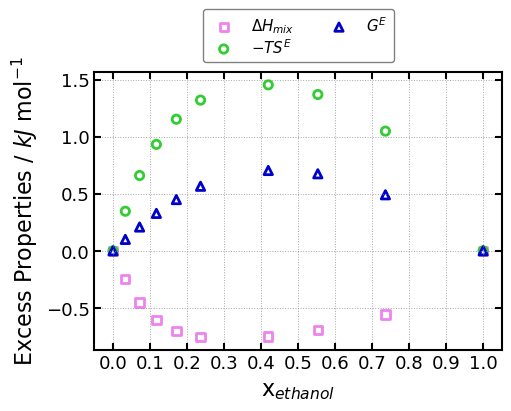

In [8]:
fig, ax = plotter.plot("excess", show=True)  # plot contributions to Gibbs excess energy

### Make an example figure showing KB Theory results

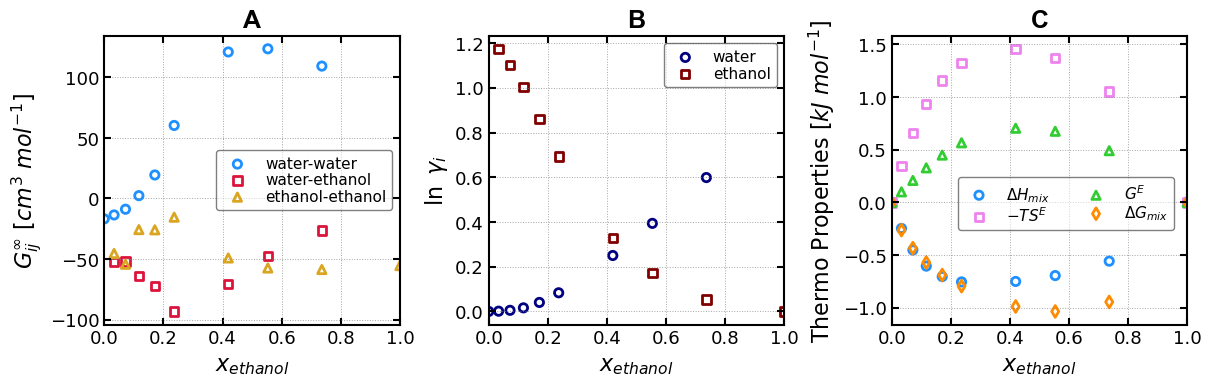

In [9]:
kbis = pipe.thermo.kbi_matrix.value
kbis_cm3_mol = pipe.convert_units("kbis", "cm^3/mol")
molmap = {"ETHOL": "ethanol", "SPCEW": "water"}
mols = pipe.state.unique_molecules
idx = mols.index("ETHOL")
x_ext = pipe.state.mol_fr[:, idx]

fig, ax = plt.subplots(1, 3, figsize=(12, 3.75))

ax[0].set_xlabel(r"$x_{{ethanol}}$")
ax[0].set_ylabel(r"$G_{{ij}}^\infty$ [$cm^3$ $mol^{{-1}}$]")
ax[0].scatter(x_ext, kbis_cm3_mol[:, 0, 0], c="dodgerblue", marker="o", label=f"{molmap[mols[0]]}-{molmap[mols[0]]}")
ax[0].scatter(x_ext, kbis_cm3_mol[:, 0, 1], c="crimson", marker="s", label=f"{molmap[mols[0]]}-{molmap[mols[1]]}")
ax[0].scatter(x_ext, kbis_cm3_mol[:, 1, 1], c="goldenrod", marker="^", label=f"{molmap[mols[1]]}-{molmap[mols[1]]}")
ax[0].legend(loc="center right")
ax[0].set_xlim(0, 1)

ax[1].set_xlabel(r"$x_{{ethanol}}$")
ax[1].set_ylabel(r"$\ln \ \gamma_i$")
ax[1].scatter(x_ext, pipe.results["lngammas"][:, 0], c="navy", marker="o", label=f"{molmap[mols[0]]}")
ax[1].scatter(x_ext, pipe.results["lngammas"][:, 1], c="maroon", marker="s", label=f"{molmap[mols[1]]}")
ax[1].legend(loc="upper right")
ax[1].set_xlim(0, 1)

ax[2].set_xlabel(r"$x_{{ethanol}}$")
ax[2].set_ylabel(r"Thermo Properties [$kJ$ $mol^{{-1}}$]")
ax[2].scatter(x_ext, pipe.results["h_mix"], c="dodgerblue", marker="o", label=r"$\Delta H_{{mix}}$")
ax[2].scatter(x_ext, -300 * pipe.results["se"], c="violet", marker="s", label=r"$-TS^E$")
ax[2].scatter(x_ext, pipe.results["ge"], c="limegreen", marker="^", label=r"$G^E$")
ax[2].scatter(x_ext, pipe.results["gm"], c="darkorange", marker="d", label=r"$\Delta G_{{mix}}$")
ax[2].legend(loc="lower right", ncol=2, bbox_to_anchor=(0.98, 0.3))
ax[2].set_xlim(0, 1)

ax[0].set_title("A", fontsize=18, fontweight="bold", family="Arial")
ax[1].set_title("B", fontsize=18, fontweight="bold", family="Arial")
ax[2].set_title("C", fontsize=18, fontweight="bold", family="Arial")
fig.savefig("pipeline_figs.png", dpi=100)

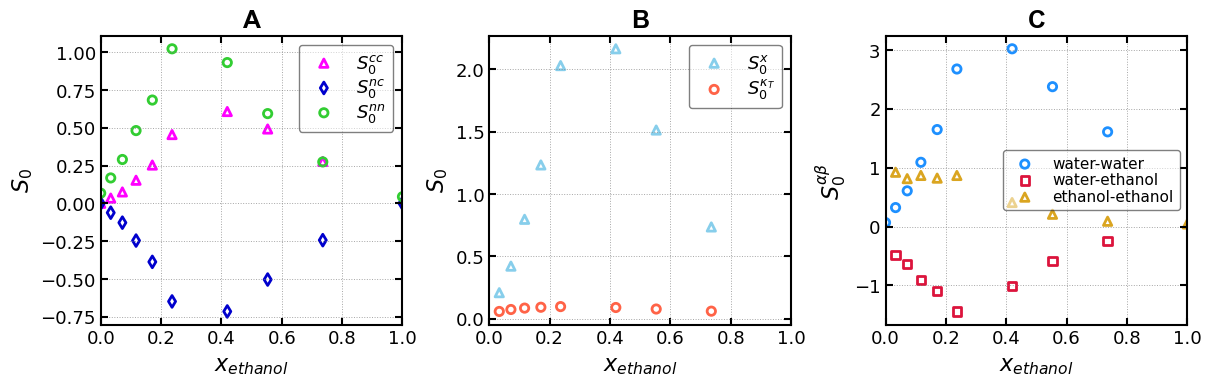

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.75), sharex=True)
ax[0].set_xlim(0, 1)

ax[0].scatter(x_ext, pipe.thermo.s0_cc.value[:, 0, 0], marker="^", c="magenta", label=r"$S_0^{cc}$")
ax[0].scatter(x_ext, pipe.thermo.s0_nc.value[:, 0], marker="d", c="mediumblue", label=r"$S_0^{nc}$")
ax[0].scatter(x_ext, pipe.thermo.s0_nn.value, marker="o", c="limegreen", label=r"$S_0^{nn}$")
ax[0].legend(fontsize=13)
ax[0].set_xlabel(r"$x_{{ethanol}}$")
ax[0].set_ylabel(r"$S_0$")

ax[1].scatter(x_ext, pipe.thermo.s0_x.value, marker="^", c="skyblue", label=r"$S_0^{x}$")
ax[1].scatter(x_ext, pipe.thermo.s0_kappa.value, marker="o", c="tomato", label=r"$S_0^{\kappa_T}$")
ax[1].legend(fontsize=13)
ax[1].set_xlabel(r"$x_{{ethanol}}$")
ax[1].set_ylabel(r"$S_0$")

molecule_map = {"SPCEW": "water", "ETHOL": "ethanol"}
mol0, mol1 = [molecule_map[mol] for mol in pipe.state.unique_molecules]

ax[2].scatter(x_ext, pipe.thermo.s0_ij.value[:, 0, 0], marker="o", c="dodgerblue", label=f"{mol0}-{mol0}")
ax[2].scatter(x_ext, pipe.thermo.s0_ij.value[:, 0, 1], marker="s", c="crimson", label=f"{mol0}-{mol1}")
ax[2].scatter(x_ext, pipe.thermo.s0_ij.value[:, 1, 1], marker="^", c="goldenrod", label=f"{mol1}-{mol1}")
ax[2].legend()
ax[2].set_xlabel(r"$x_{{ethanol}}$")
ax[2].set_ylabel(r"$S_0^{\alpha \beta}$")

ax[0].set_title("A", fontsize=18, fontweight="bold", family="Arial")
ax[1].set_title("B", fontsize=18, fontweight="bold", family="Arial")
ax[2].set_title("C", fontsize=18, fontweight="bold", family="Arial")

fig.savefig("scattering_figs_s0.png", dpi=100)

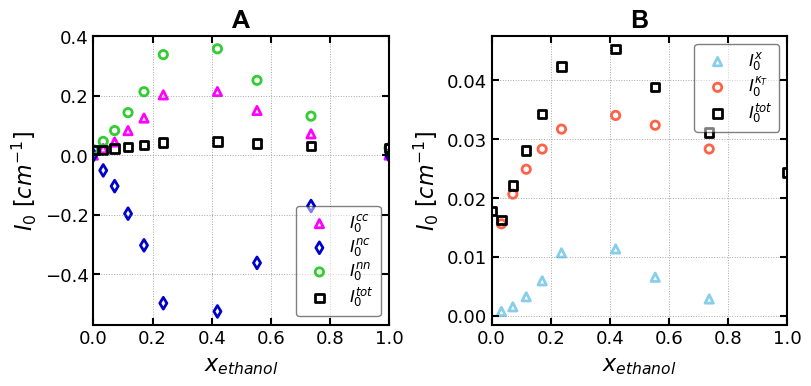

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.75), sharex=True)
ax[0].scatter(x_ext, pipe.thermo.i0_cc.value, marker="^", c="magenta", label=r"$I_0^{cc}$")
ax[0].scatter(x_ext, pipe.thermo.i0_nc.value, marker="d", c="mediumblue", label=r"$I_0^{nc}$")
ax[0].scatter(x_ext, pipe.thermo.i0_nn.value, marker="o", c="limegreen", label=r"$I_0^{nn}$")
ax[0].scatter(x_ext, pipe.thermo.i0.value, marker="s", c="k", label=r"$I_0^{tot}$")
ax[0].legend(fontsize=12)

ax[1].scatter(x_ext, pipe.thermo.i0_x.value, marker="^", c="skyblue", label=r"$I_0^{x}$")
ax[1].scatter(x_ext, pipe.thermo.i0_kappa.value, marker="o", c="tomato", label=r"$I_0^{\kappa_T}$")
ax[1].scatter(x_ext, pipe.thermo.i0.value, marker="s", c="k", label=r"$I_0^{tot}$")
ax[1].legend(fontsize=12)


ax[0].set_xlim(0, 1)
ax[0].set_xlabel(r"$x_{{ethanol}}$")
ax[1].set_xlabel(r"$x_{{ethanol}}$")
ax[0].set_ylabel(r"$I_0 \ [cm^{-1}]$")
ax[1].set_ylabel(r"$I_0 \ [cm^{-1}]$")

ax[0].set_title("A", fontsize=18, fontweight="bold", family="Arial")
ax[1].set_title("B", fontsize=18, fontweight="bold", family="Arial")
fig.savefig("scattering_figs_i0.png", dpi=100)

### Inspecting RDF Convergence

In [48]:
import numpy as np

from kbkit.analysis import KBIntegrator
from kbkit.core import SystemProperties

prj1 = "test_data/ethanol_water_26C"
sys_path = os.path.join(prj1, "sys_405")
rdf_file = "rdf_ETHOL_SPCEW.xvg"
rdf_path = os.path.join(sys_path, "kbi_rdf_files_gmx25", rdf_file)

kbi = KBIntegrator(
    rdf_file=rdf_path,
    system_properties=SystemProperties(sys_path),
    use_fixed_rmin=False,
)
kbi.mol_j = rdf_file.split("_")[2].strip(".xvg")
params = kbi.fit_kbi_inf()
xfit = kbi.lambda_ratio()[kbi.rdf.r_mask]

### Plot RDF Convergence Results

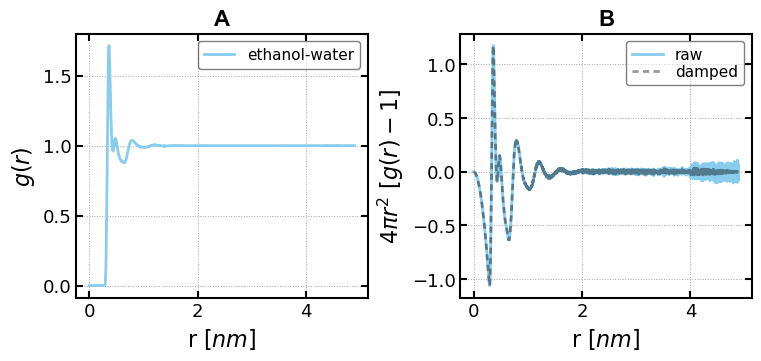

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 3.5))

ax[0].plot(kbi.rdf.r, kbi.rdf.g, label="ethanol-water")
ax[0].set_xlabel(r"r [$nm$]")
ax[0].set_ylabel(r"$g(r)$")
ax[0].legend()

ax[1].plot(kbi.rdf.r, 4 * np.pi * kbi.rdf.r**2 * kbi.h(), label="raw")
ax[1].plot(kbi.rdf.r, kbi.window() * kbi.h(), c="k", alpha=0.4, ls="--", label="damped")
ax[1].set_xlabel(r"r [$nm$]")
ax[1].set_ylabel(r"$4 \pi r^2 \ [g(r) - 1]$")
ax[1].legend()

ax[0].set_title("A", fontsize=16, fontweight="bold", family="Arial")
ax[1].set_title("B", fontsize=16, fontweight="bold", family="Arial")
# ax[1].set_ylim(-0.5,0.5)
fig.savefig("rdf_inspect.png", dpi=100)

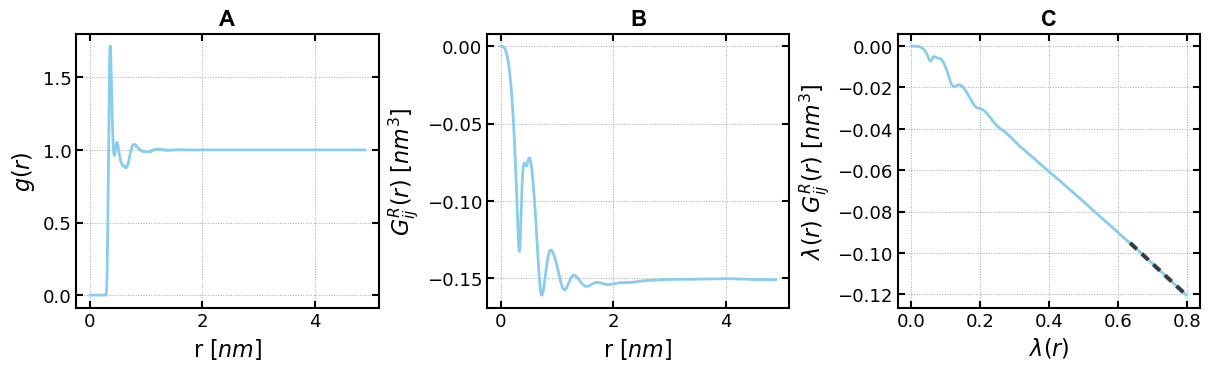

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.6))

ax[0].plot(kbi.rdf.r, kbi.rdf.g)
ax[0].set_xlabel(r"r [$nm$]")
ax[0].set_ylabel(r"$g(r)$")

ax[1].plot(kbi.rdf.r, kbi.running_kbi())
ax[1].set_xlabel(r"r [$nm$]")
ax[1].set_ylabel(r"$G_{{ij}}^R(r)$ [$nm^3$]")

ax[2].plot(kbi.lambda_ratio(), kbi.lambda_ratio() * kbi.running_kbi())
ax[2].plot(xfit, np.polyval(params, xfit), c="k", alpha=0.7, ls="--", lw=3)
ax[2].set_xlabel(r"$\lambda(r)$")
ax[2].set_ylabel(r"$\lambda(r) \ G_{{ij}}^R(r)$ [$nm^3$]")

ax[0].set_title("A", fontsize=16, fontweight="bold", family="Arial")
ax[1].set_title("B", fontsize=16, fontweight="bold", family="Arial")
ax[2].set_title("C", fontsize=16, fontweight="bold", family="Arial")
fig.savefig("kbi_extrap.png", dpi=100)